In [1]:

import torch
from torch.nn.parameter import Parameter
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


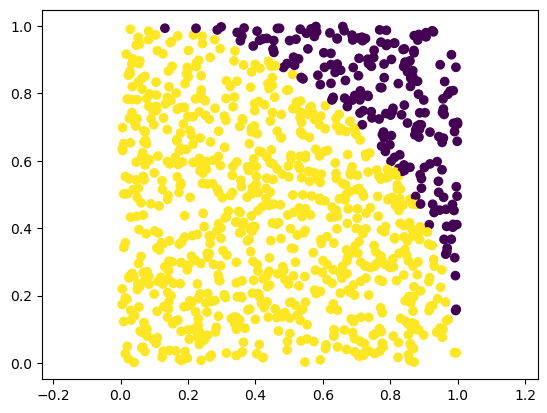

In [2]:
# Same as before...
x = torch.rand([1000,2])
x_in_circle = ((x**2).sum(1) < 1)

def accuracy(pred_label):
    return (pred_label==x_in_circle).float().mean()

def show(pred_label):
    scatter(*x.numpy().T, c=pred_label.numpy())
    axis('equal')

def loss(prediction):
    return -(x_in_circle.float()     * (prediction+1e-10).log() +
             (1-x_in_circle.float()) * (1-prediction+1e-10).log() ).mean()

class Linear(torch.nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.w = Parameter(torch.zeros(input_dim))
        self.b = Parameter(-torch.zeros(1))
    
    def forward(self, x):
        return (x * self.w[None,:]).sum(dim=1) + self.b

class LinearClassifier(torch.nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.linear = Linear(input_dim)
    
    def forward(self, x):
        logit = self.linear(x)
        return 1/(1+(-logit).exp())

show(x_in_circle)

In [3]:
# Start tensorboard session
import torch.utils.tensorboard as tb
%load_ext tensorboard
import tempfile
log_dir = tempfile.mkdtemp()
%tensorboard --logdir {log_dir} --reload_interval 1

2024-01-24 18:42:52.639257: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


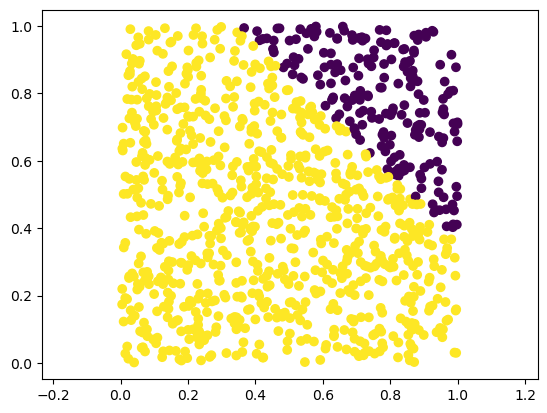

In [4]:
# setup logging
logger = tb.SummaryWriter(log_dir+'/linear1')

# Setup model
classifier = LinearClassifier(2) # linear classifier, takes 2 arguments as input

for iteration in range(10000):
    
    # Predicting the labels (and probabilities) p_y = prob, pred_y = labels
    p_y = classifier(x)
    pred_y = p_y > 0.5

    # Compute the loss
    l = loss(p_y)
    
    # Log loss and accuracy
    logger.add_scalar("loss", l, global_step=iteration)
    logger.add_scalar("accuracy", accuracy(pred_y), global_step=iteration)
    
    if iteration % 100 == 0:
        fig = figure()
        show(pred_y)
        logger.add_figure('pred_y', fig, global_step=iteration)
        del fig
    
    # Compute the gradient (runs backpropogation)
    l.backward()

    # Update weights using gradient descent (GD)
    for p in classifier.parameters():
        p.data[:] -= 0.5 * p.grad # Update value
        p.grad.zero_() # Reset the gradient to zero

show(pred_y)

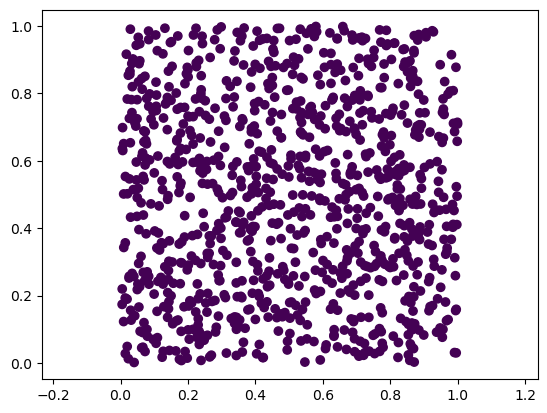

In [5]:
# Non-linear Classifier, multi-layered
class NonLinearClassifier(torch.nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.linear1 = torch.nn.Linear(input_dim, 100) # first linear layer, certain input diemnsion, 100 outputs
        torch.nn.init.normal_(self.linear1.weight, std=0.01)  #initialize weights of that layer
        torch.nn.init.normal_(self.linear1.bias, std=0.01) # initialize biases of first layer
        self.linear2 = Linear(100) # second linear layer, takes 100 inputs, produces one prediction
    
    def forward(self, x): # new forward function
        logit = self.linear2( torch.relu(self.linear1(x)) ) # uses linear1 and linear2
        return 1/(1+(-logit).exp())


classifier = NonLinearClassifier(2)
show(classifier(x).detach() > 0.5)

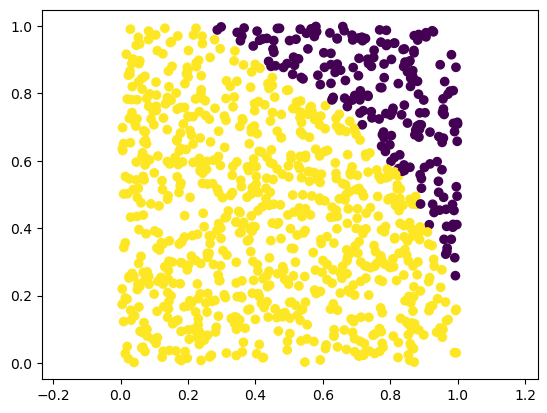

In [6]:
# using same training code as before....


# Log nonlinear layer
logger = tb.SummaryWriter(log_dir+'/nonlinear1')

classifier = NonLinearClassifier(2) # just change out classifier

for iteration in range(10000):
    p_y = classifier(x)
    pred_y = p_y > 0.5
    l = loss(p_y)
    
    logger.add_scalar("loss", l, global_step=iteration)
    logger.add_scalar("accuracy", accuracy(pred_y), global_step=iteration)
    
    if iteration % 100 == 0:
        fig = figure()
        show(pred_y)
        logger.add_figure('pred_y', fig, global_step=iteration)
        del fig
    
    l.backward()
    for p in classifier.parameters():
        p.data[:] -= 0.5 * p.grad
        p.grad.zero_()

show(pred_y)